In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
from statistics import median
from rsi import apply as rsi

import pyfinancialdata
import trade_functions

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=True,
)

In [3]:
# Add column for RSI to use as a feature for learning
price_data['rsi'] = rsi(price_data['price'])
environment_columns = ['rsi', 'price']

# Drop NA columns and reset index
price_data.dropna(inplace=True)

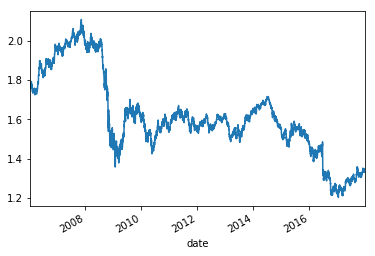

In [4]:
price_data['price'].plot()

In [5]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(drop=True, inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(drop=True, inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 4662, test size 2331


In [6]:
episode=600
batch_size=2

In [7]:
train_data.head(5)

,price,rsi
0,1.76875,79.629768
1,1.76420,72.043558
2,1.75745,62.568899
3,1.76660,68.571885
4,1.76835,69.571862


In [8]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [9]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    if (e + 1) % 50 == 0:
        agent.save('{}-dqn.h5'.format(time.strftime('%Y%m%d%H%M')))



....................
episode: 20/600
median profit: -951 pips, median trade count: 486
....................
episode: 40/600
median profit: 1066 pips, median trade count: 1089
....................
episode: 60/600
median profit: 1968 pips, median trade count: 1196
....................
episode: 80/600
median profit: 2086 pips, median trade count: 1252
....................
episode: 100/600
median profit: 2366 pips, median trade count: 1351
..........

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


..........
episode: 120/600
median profit: 2494 pips, median trade count: 1434
....................
episode: 140/600
median profit: 2761 pips, median trade count: 1464
....................
episode: 160/600
median profit: 2777 pips, median trade count: 1464
....................
episode: 180/600
median profit: 2761 pips, median trade count: 1406
....................
episode: 200/600
median profit: 2366 pips, median trade count: 1384
....................
episode: 220/600
median profit: 2086 pips, median trade count: 1366
....................
episode: 240/600
median profit: 1968 pips, median trade count: 1346
....................
episode: 260/600
median profit: 1726 pips, median trade count: 1311
....................
episode: 280/600
median profit: 1693 pips, median trade count: 1302
....................
episode: 300/600
median profit: 1547 pips, median trade count: 1282
....................
episode: 320/600
median profit: 1428 pips, median trade count: 1287
....................
episode: 3

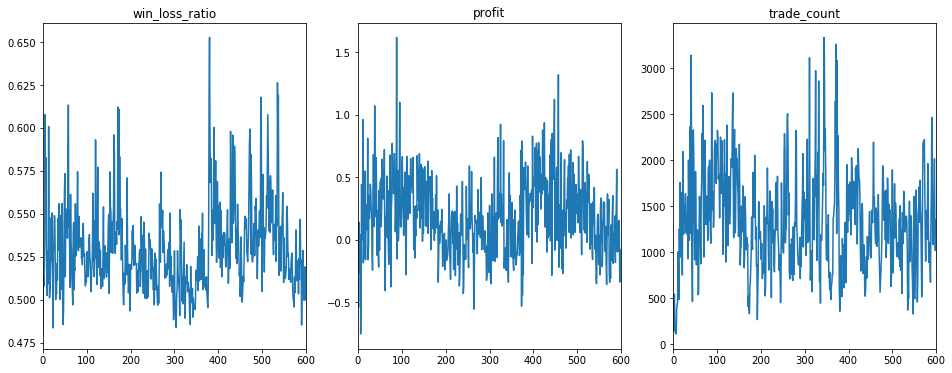

In [10]:
train_results['profit'] = train_results['account_balance']
columns_to_plot = ['win_loss_ratio', 'profit', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

## Test

In [15]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

# Uncomment to load trained model from latest saved
# agent = DQNAgent(state_size, action_size)
# latest_model_file = max(glob.glob('*.h5'), key=os.path.getctime)
# print('loading model: {0}'.format(latest_model_file))
# agent.load(latest_model_file)

In [16]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [23]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 226.65000000003818 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x134234290>]],
      dtype=object)

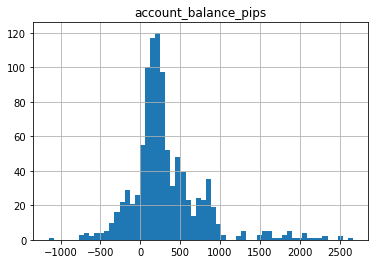

In [24]:
test_results.hist(column='account_balance_pips', bins=60)